# Ni microspectrocopy data from BNL

In [1]:
from PIL import Image, ImageSequence
from ipywidgets import IntSlider, widgets, interactive, fixed
import itertools

import numpy as np

import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from matplotlib.animation import FuncAnimation, PillowWriter
import mplcursors
from matplotlib import gridspec
import matplotlib.patches as mpatches

from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.metrics.pairwise import cosine_similarity
import umap
from sklearn.manifold import TSNE

Missing reference data in HXN folder

In [2]:
def parse_tiff(filename):
    img = Image.open(filename)
    data = np.array(img)
    N = 0
    for i, page in enumerate(ImageSequence.Iterator(img)):
        N += 1
    Data = np.zeros((N, data.shape[0], data.shape[1]))
    for i, page in enumerate(ImageSequence.Iterator(img)):
        Data[i] = np.array(page)
    return Data

1. Fe_xanes (from HXN) is a model system sample used for optimizing nano-XANES workflow. We know the "true value" chemical state map. The aggregate is composed of LiFe(II)PO4 (LFP), Pyrite (Pyr), StainlessSteelNP (SS) and Hematite_NP (Hem). Please note that this is unpublished data from a submitted MS

2. Ni_xanes is an unknown sample?

(101, 320, 320)
(73, 155, 160)


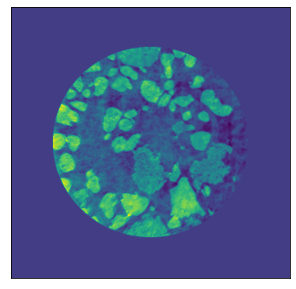

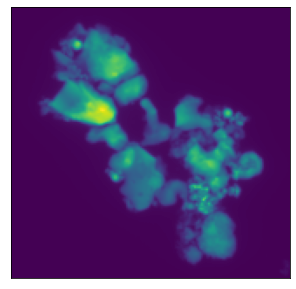

In [3]:
Ni_xanes = parse_tiff('Data/TXM_XANES/Ni_xanes.tiff')
Fe_xanes = parse_tiff('Data/HXN_XANES/nanoXANES_Fe.tiff')

def plot_img(data):
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.imshow(data, extent=[0, 1, 0, 1], aspect='auto')
    ax.set_xticks([])
    ax.set_yticks([])

print(Ni_xanes.shape)
print(Fe_xanes.shape)

plot_img(np.average(Ni_xanes, axis=0))
plot_img(np.average(Fe_xanes, axis=0))

In [4]:
def plot_spectra(i, Data):
    fig, ax = plt.subplots(figsize=(5, 5))    
    data = Data[i]
    ax.imshow(data, extent=[0, 1, 0, 1], aspect='auto')
    ax.set_xticks([])
    ax.set_yticks([])
    plt.show()
        

data = Fe_xanes
slider = IntSlider(min=0, max=len(data) - 1, step=1, value=0,
                   layout=widgets.Layout(width='50%'))
interactive(plot_spectra, i=slider, Data=fixed(data))

interactive(children=(IntSlider(value=0, description='i', layout=Layout(width='50%'), max=72), Output()), _dom…

In [5]:
def remove_ticks(ax):
    ax.set_xticks([])
    ax.set_yticks([])

def add_point_label(pickable, data, ax):
    """Add point label."""
    def onselect(sel):
        x, y = sel.target.index[0], sel.target.index[1]
        annotation = f'({x}, {y})'
        sel.annotation.set_text(annotation)
        spectrum = data[:, x, y]
        ax.clear()
        ax.plot(np.arange(len(spectrum)), spectrum, linestyle='-', linewidth=2, c=plt.cm.tab10(7))
        remove_ticks(ax)
    mplcursors.cursor(pickable, highlight=True).connect("add", onselect)

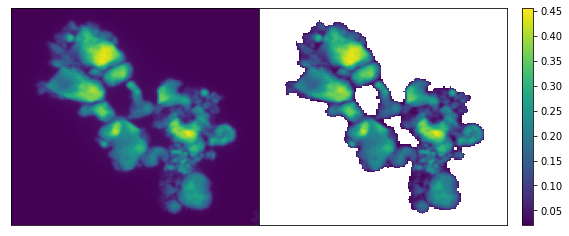

In [131]:
data = Fe_xanes

def get_filtered_img(data, threshold=0.02, return_mask=False):
    mask = np.zeros((data.shape[0], data.shape[1], data.shape[2]))
    bool_arr = np.max(Fe_xanes, axis=0) < threshold
    mask[:, bool_arr] = 1
    filtered_img = np.ma.array(data, mask=mask)
    if return_mask:
        return filtered_img, mask
    else:
        return filtered_img

fig = plt.figure(figsize=(10, 4))
spec = fig.add_gridspec(ncols=2, width_ratios=[0.8, 1.])
plt.subplots_adjust(wspace=0.)

ax = fig.add_subplot(spec[0])
ax.imshow(np.max(data, axis=0), extent=[0, 1, 0, 1], aspect='auto')
ax = fig.add_subplot(spec[1])
img = ax.imshow(np.max(get_filtered_img(data), axis=0), extent=[0, 1, 0, 1], aspect='auto')

for ax in fig.get_axes():
    remove_ticks(ax)

plt.colorbar(img)
plt.show()

In [132]:
%matplotlib inline

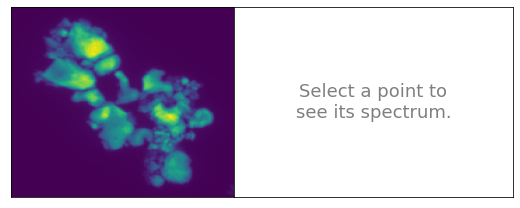

In [133]:
data = Fe_xanes

fig = plt.figure(figsize=(9, 3.5))
spec = fig.add_gridspec(ncols=2, width_ratios=[0.8, 1.])
plt.subplots_adjust(wspace=0.)

ax = fig.add_subplot(spec[0])
img = ax.imshow(np.max(data, axis=0), extent=[0, 1, 0, 1], aspect='auto')

ax = fig.add_subplot(spec[1])
ax.text(0.5, 0.5, "Select a point to\nsee its spectrum.", fontsize=18, ha='center', va='center',
        c=plt.cm.tab10(7))

for ax in fig.get_axes():
    remove_ticks(ax)

add_point_label(img, data, ax)

1. pca -> umap -> dbscan to cluster based on spectral similarity? Can this filter out background?
2. find spectral average for each cluster (excluding background) -> LCF -> same as expected results?

# PCA

In [134]:
def make_scree_plot(data, n=5, threshold=0.95, show_first_PC=True, mod=0, c=0):
    fig, ax = plt.subplots(figsize=(8,6))
    pca = PCA()
    pca_components = pca.fit_transform(data)

    n_components = 0
    x = np.arange(n) + 1
    cdf = [np.sum(pca.explained_variance_ratio_[:i + 1]) for i in range(n)]
    for i, val in enumerate(cdf):
        if val > threshold:
            print(f"It takes {i + 1} PCs to explain {int(threshold*100)}% variance.")
            n_components = i + 1
            break

    ax.plot(x, cdf, 's-', markersize=10, fillstyle='none',
            color=plt.cm.tab10(c))
    ax.plot(x, np.ones(len(x)) * threshold, 'k--', linewidth=3)

    if show_first_PC:
        PC1 = pca.components_[0]
        plt.plot(np.linspace(1, n, len(PC1)), -PC1*0.3 + min(cdf) + 0.05, 'k', linewidth=2)
        text = ax.text(n - 1, min(cdf) + 0.06, '$PC_1$', ha="right", va="bottom", size=20)

    if mod == 0:
        xticks = np.arange(n) + 1
    else:
        xticks = np.arange(0, n + 1, mod)
    plt.xticks(xticks, fontsize=18)
    plt.yticks(fontsize=18)
    plt.ylim(min(cdf) - 0.05, 1.02)
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    plt.xlabel('Number of Parameters', fontsize=22)
    plt.ylabel(f'Cumultative\nExplained Variance', fontsize=22)
    ax.tick_params(direction='in', width=2, length=8)
    
    return n_components

In [136]:
data = Fe_xanes
fd, mask = get_filtered_img(data, return_mask=True)

filtered_spectra_dict = {}
for x in range(fd.shape[1]):
    for y in range(fd.shape[2]):
        if mask[0, x, y] == False:
            spectrum = fd[:, x, y]
            filtered_spectra_dict[(x, y)] = spectrum
filtered_spectra = np.array(list(filtered_spectra_dict.values()))

It takes 4 PCs to explain 99% variance.


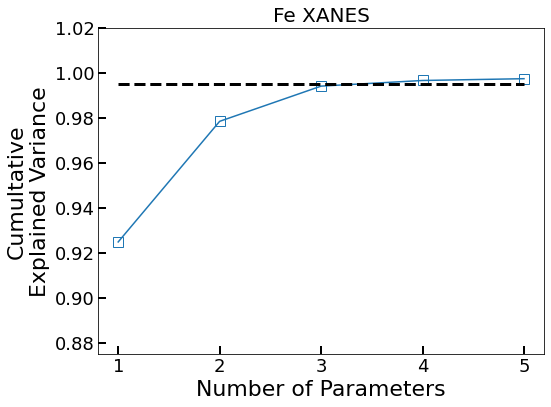

In [138]:
data = filtered_spectra
data = data / np.max(data)
n_components = make_scree_plot(data, n=5, c=0, threshold=0.995, show_first_PC=False)
plt.title('Fe XANES', fontsize=20)
plt.show()

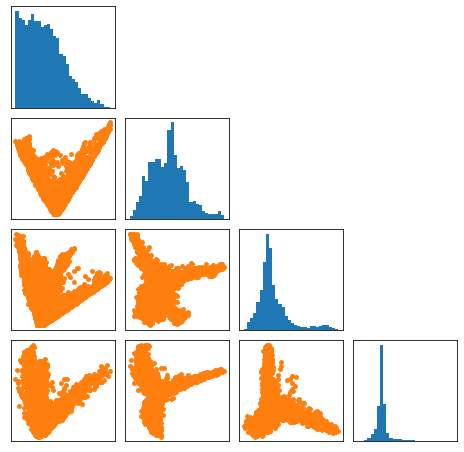

In [139]:
pca = PCA(n_components=n_components)
pca_components = pca.fit_transform(filtered_spectra)

fig, axes = plt.subplots(figsize=(2 * n_components, 2 * n_components),
                         ncols=n_components, nrows=n_components)
plt.subplots_adjust(wspace=0.1, hspace=0.1)

for i in np.arange(n_components):
    for j in np.arange(n_components):
        ax = axes[i, j]
        if i == j:
            ax.hist(pca_components[:, i], color=plt.cm.tab10(0), bins=30)
            ax.set_xticks([])
            ax.set_yticks([])
        elif j < i:
            ax.scatter(pca_components[:, i], pca_components[:, j], marker='o', s=15, 
                       color=plt.cm.tab10(1))
            ax.set_xticks([])
            ax.set_yticks([])
        else:
            ax.axis('off')
plt.show()

# UMAP

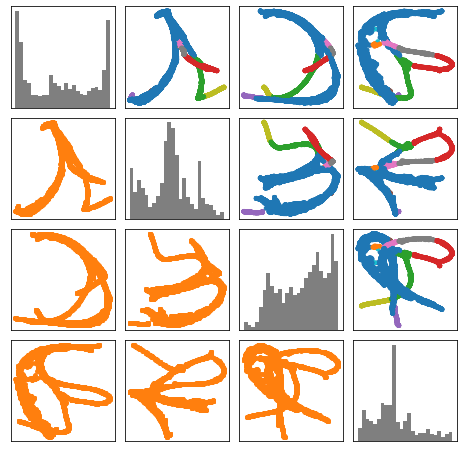

In [159]:
n_neighbors = 18
min_dist = 0.1
dimension = 4
reducer = umap.UMAP(random_state=42, n_components=dimension,
                    n_neighbors=n_neighbors, min_dist=min_dist)
reduced_space = reducer.fit_transform(pca_components)

dbscan_clustering = DBSCAN(eps=0.4, min_samples=1).fit(reduced_space)
colors = [plt.cm.tab10(label) for label in dbscan_clustering.labels_]
cdict = {tup: colors[i] for i, tup in enumerate(list(filtered_spectra_dict.keys()))}

fig, axes = plt.subplots(figsize=(2 * dimension, 2 * dimension),
                         ncols=dimension, nrows=dimension)
plt.subplots_adjust(wspace=0.1, hspace=0.1)

for i in np.arange(dimension):
    for j in np.arange(dimension):
        ax = axes[i, j]
        if i == j:
            ax.hist(reduced_space[:, i], color=plt.cm.tab10(7), bins=25)
        elif j < i:
            ax.scatter(reduced_space[:, i], reduced_space[:, j], marker='o', s=15, 
                       color=plt.cm.tab10(1))
        else:
            #ax.axis('off')
            ax.scatter(reduced_space[:, j], reduced_space[:, i], marker='o', s=15, 
                       color=colors)
        ax.set_xticks([])
        ax.set_yticks([])
plt.show()

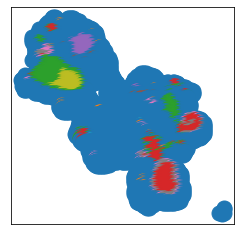

In [163]:
fig, ax = plt.subplots(figsize=(4, 4))
for key in list(filtered_spectra_dict.keys()):
    spectrum = filtered_spectra_dict[key]
    x, y = key
    ax.plot(y, -x, color=cdict[key], marker='o', markersize=15)
remove_ticks(ax)
plt.show()